# Softmagnetic Composite


## Google Colab Link

The demo can be run on Google Colab without any local installation.
Use the following [link](https://colab.research.google.com/drive/1HazB7ydSYZKbtrQoPc9xE3U0d7uc-1Ir) to try it out.

In [6]:
!pip install -q magnumnp numpy==1.22.4

## Run Demo:

In [7]:
from magnumnp import *
import torch

#SIZE_CUBE = 900e-9
#gap = 23.08 14.29 9.09 6.98 4.35
#Ni = 13 21 33 43 69
#N = 3*Ni + 1 = 40 64 100 130 208

N = 40
Timer.enable()

# initialize state
eps = 1e-15
Nx, Ny, Nz = 3, 3, 3
nx, ny, nz = N, N, N
dx, dy, dz = 900e-9 / (N-1), 900e-9 / (N-1), 900e-9 / (N-1)

mesh = Mesh((nx,ny,nz), (dx,dy,dz))
state = State(mesh)
state.m = state.Constant((0,0,1))
state.material = {"alpha": 1.0}

state.material["Ms"] = state.Constant([0.0001/constants.mu_0])
state.material["Ms"][nx%Nx:,ny%Ny:,nz%Nz:] = 1.5/constants.mu_0

state.material["A"] = state.Constant([0.])
state.material["A"][nx%Nx:,ny%Ny:,nz%Nz:] = 10e-12

state.material["Ku"] = state.Constant([0.])
state.material["Ku"][nx%Nx:,ny%Ny:,nz%Nz:] = 8e3

k_dir = state.Tensor(((1.688281290426342229e-01, -7.18775080428410873e-01, 6.744326850020654351e-01),
                      (-1.24488794472133734e-02, 8.827421556265807601e-01, 4.696927847862328309e-01),
                      (4.360199027887372986e-02, 9.960452028850761419e-01, -7.74133079860866157e-02),
                      (3.749512630383480816e-01, 6.881354883832631053e-01, -6.21193287128471327e-01),
                      (8.860065554198717219e-01, 2.300892602270045995e-01, -4.02555978816864223e-01),
                      (-7.89116308031293234e-02, -7.44290764462179010e-01, -6.63177361239280949e-01),
                      (1.534426618908853179e-01, 6.661409155280296757e-01, 7.298709681658244186e-01),
                      (3.629777351625293469e-02, 7.384491837339980380e-01, 6.733314745950575997e-01),
                      (-6.22338299750334056e-01, -4.54495719851937984e-01, -6.37282261874698607e-01),
                      (5.091810893444697061e-01, -7.86185846048253700e-01, 3.502091285608797122e-01),
                      (-7.42309465286212555e-01, 5.245654409560085440e-01, 4.169025736321682052e-01),
                      (2.976579786344664136e-01, 5.698206235530806074e-01, -7.65966177274703174e-01),
                      (6.783747177775549531e-02, -5.13898942407917780e-01, 8.551642850440059895e-01),
                      (-4.09811740153190107e-01, -6.51000036118079772e-01, -6.38947017057653221e-01),
                      (-4.35391566957816666e-01, 7.000228998401875069e-01, -5.66040743340399221e-01),
                      (-3.67275369838029608e-01, -9.06849357668608080e-01, -2.06719726214920074e-01),
                      (-7.24876157150795674e-01, 2.752762585295002173e-01, -6.31488351661607993e-01),
                      (7.999944917638109887e-01, -5.94809366836661745e-01, -7.88075521186358679e-02),
                      (-6.38660840611896762e-01, -7.30613237722315789e-01, -2.41488359002706959e-01),
                      (5.978837032381554284e-01, -9.09378167932159697e-02, 7.964078043810925989e-01),
                      (-9.29805720633694821e-01, -3.57570345696486047e-01, 8.720533100304592167e-02),
                      (4.682836169203208332e-01, -6.07627185281937154e-01, -6.41482390896564447e-01),
                      (7.309975652323822404e-01, 1.317784064962062851e-01, -6.69534921572915164e-01),
                      (-1.26449163913964823e-01, -9.90975538690972102e-01, -4.44757311530326326e-02),
                      (4.076648517742982869e-01, 5.753823407754260488e-01, 7.090448015123099745e-01),
                      (3.803260297965609382e-01, 9.217214425940288836e-01, 7.603744683751342825e-02),
                      (-7.25468075571367832e-01, 2.563257490022778362e-01, -6.38743439672923241e-01))).reshape(3,3,3,3)
k_dir = k_dir.repeat_interleave(nx//Nx,0).repeat_interleave(ny//Ny,1).repeat_interleave(nz//Nz,2)

state.material["Ku_axis"] = state.Constant([1,1,1])
state.material["Ku_axis"][nx%Nx:,ny%Ny:,nz%Nz:,:] = k_dir

write_vti(state.material, "data/material.vti", state)

# initialize field terms
demag    = DemagFieldPBC()
exchange = ExchangeFieldPBC()
aniso    = UniaxialAnisotropyField()
external = ExternalField(TimeInterpolator(state, {0.0e-9: [0.0, 0.0, 0.0],
                                                  1.0e-9: [0.0, 0.0, 0.0],
                                                  3.5e-9: [0.1/constants.mu_0, 0.0, 0.0],
                                                  8.5e-9: [-0.1/constants.mu_0, 0.0, 0.0],
                                                 13.5e-9: [0.1/constants.mu_0, 0.0, 0.0]}))

# perform integration
llg = LLGSolver([demag, exchange, aniso, external])
logger = ScalarLogger("data/m.dat", ['t', external.h, 'm'])

while state.t < 13.5e-9-eps:
    llg.step(state, 1e-10)
    logger << state

Timer.print_report()

2023-05-08 12:31:43  magnum.np:INFO [State] running on device: cpu (dtype = float64)
2023-05-08 12:31:43  magnum.np:INFO [Mesh] 40x40x40 (size= 2.30769e-08 x 2.30769e-08 x 2.30769e-08)
2023-05-08 12:31:43  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)
2023-05-08 12:31:48  magnum.np:INFO [LLG] step: dt= 1e-10  t=1e-10
2023-05-08 12:31:50  magnum.np:INFO [LLG] step: dt= 1e-10  t=2e-10
2023-05-08 12:31:52  magnum.np:INFO [LLG] step: dt= 1e-10  t=3e-10
2023-05-08 12:31:55  magnum.np:INFO [LLG] step: dt= 1e-10  t=4e-10
2023-05-08 12:31:58  magnum.np:INFO [LLG] step: dt= 1e-10  t=5e-10
2023-05-08 12:32:02  magnum.np:INFO [LLG] step: dt= 1e-10  t=6e-10
2023-05-08 12:32:05  magnum.np:INFO [LLG] step: dt= 1e-10  t=7e-10
2023-05-08 12:32:07  magnum.np:INFO [LLG] step: dt= 1e-10  t=8e-10
2023-05-08 12:32:10  magnum.np:INFO [LLG] step: dt= 1e-10  t=9e-10
2023-05-08 12:32:12  magnum.np:INFO [LLG] step: dt= 1e-10  t=1e-09
2023-05-08 12:32:14  magnum.np:INFO [LLG] step: dt= 1e-10  t=1.

KeyboardInterrupt: 

## Plot Results

In [ ]:
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/softmagnetic_composite/ref/m_ref.dat

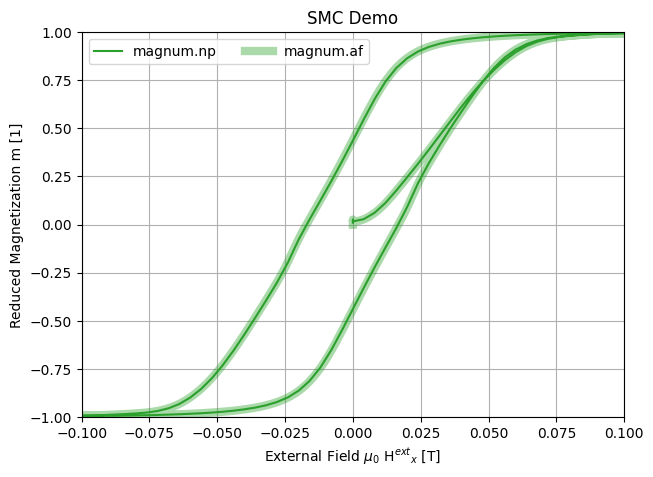

IOStream.flush timed out


In [5]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("data/m.dat")
ref = np.loadtxt("ref/m_ref.dat")



fig, ax = plt.subplots(figsize=(7,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(data[:,1]*4*np.pi*1e-7, data[:,4], '-', color = cycle[2], label = "magnum.np")
ax.plot(ref[:,1]*4*np.pi*1e-7, ref[:,4], '-', color = cycle[2], linewidth = 6, alpha = 0.4, label = "magnum.af")

ax.set_xlim([-0.1,0.1])
ax.set_ylim([-1,1])
ax.set_title("SMC Demo")
ax.set_xlabel("External Field $\mu$$_0$ H$^{ext}$$_x$ [T]")
ax.set_ylabel("Reduced Magnetization m [1]")
ax.legend(ncol=3)
ax.grid()
fig.savefig("data/results.png")
